In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import jax
import jax_cosmo as jc
import jax.numpy as np
from DifferentiableHOS.Plot import plot_contours
cosmo_jax = jc.Planck15()

Populating the interactive namespace from numpy and matplotlib


In [72]:
ps_array=[]
jac_array=[]
for i in (range(11)):
    results_dict = pickle.load( open( "/Users/dl264294/Desktop/github/DifferentiableHOS/scripts/results"+str(i)+".pkl", "rb" ) )
    ps=results_dict['ps']
    jac=results_dict['jac']
    ps_array.append(ps)
    jac_array.append(jac)
ell=results_dict['ell']

In [73]:
ps=np.mean(np.stack(ps_array),axis=0)
jac=np.mean(np.stack(jac_array),axis=0)

In [74]:
cosmo=jc.Planck15()
nz =jc.redshift.delta_nz(1.)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, ell[0], probes)
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell[0], probes,f_sky=25/41252, sparse=True);


/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [75]:
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell[0], probes)
  return m.flatten()
jac_mean = jax.jit(jax.jacfwd(mean_fn))
params = np.array([cosmo.Omega_c, cosmo.sigma8]) 
dmu = jac_mean(params)


In [76]:
F = jc.sparse.dot(dmu.T, jc.sparse.inv(cov), dmu)
F1= jc.sparse.dot(jac.T, jc.sparse.inv(cov), jac)

Populating the interactive namespace from numpy and matplotlib


/Users/dl264294/.conda/envs/env_nbody/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cov']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Text(0.5, 1.0, 'Comparison to Jax-cosmo halofit (dashed)')

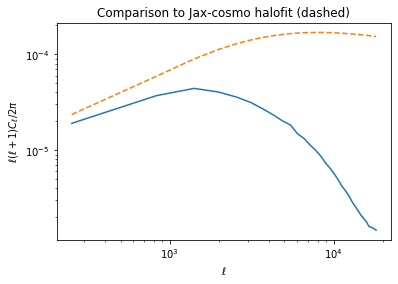

In [77]:
%pylab inline
l=ell[0]
loglog(l, l*(l+1)*ps/(2*pi))
loglog(l, l*(l+1)*cls[0]/(2*pi), '--',)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
#xlim(1,1e3)
xlabel('$\ell$')
title('Comparison to Jax-cosmo halofit (dashed)')

Populating the interactive namespace from numpy and matplotlib


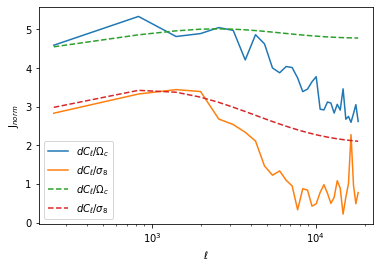

In [78]:
%pylab inline
semilogx(ell[0],jac[:,0]/ps,label='$dC_\ell/\Omega_c$')
semilogx(ell[0],jac[:,1]/ps,label='$dC_\ell/\sigma_8$')
semilogx(ell[0],dmu[:,0]/cls[0],'--',label='$dC_\ell/\Omega_c$')
semilogx(ell[0],dmu[:,1]/cls[0],'--',label='$dC_\ell/\sigma_8$')
ylabel('J$_{norm}$')
xlabel('$\ell$')
#xlim(0,3000)
#savefig('momcomp6.png',dpi=80)
legend()

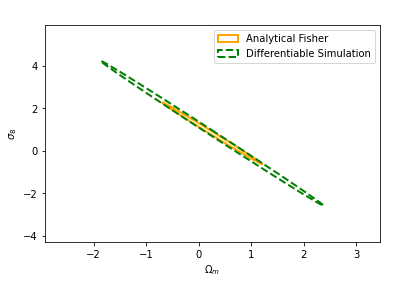

In [79]:
ax = plt.axes()
#ax.set_facecolor('black')
ax1=plot_contours(F, params, fill=False,label='Analytical Fisher',color='orange', lw=2,);
ax2=plot_contours(F1, params, fill=False,label='Differentiable Simulation', color='green', lw=2, linestyle='dashed');
#ax.tick_params(colors='white', which='both')
xlabel('$\Omega_m$')#,color='white')
ylabel('$\sigma_8$')#,color='white');
title('Forecasted constraints on $\Omega_m$ and $\sigma_8$ from Power Spectrum ',color='white')
plt.legend([ax1,ax2],['Analytical Fisher','Differentiable Simulation'])
#savefig('fisher_black.png',dpi=150)

In [114]:
el=ell[0][:5]
ja=jac[:5]

In [115]:

cls_r = jc.angular_cl.angular_cl(cosmo, el, probes)
mu_r, cov_r = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, el, probes,f_sky=25/41252, sparse=True);
def mean_fn_r(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, el, probes)
  return m.flatten()
jac_mean_r = jax.jit(jax.jacfwd(mean_fn_r)) 
dmu_r = jac_mean_r(params)

In [116]:
F_r = jc.sparse.dot(dmu_r.T, jc.sparse.inv(cov_r), dmu_r)
F1_r= jc.sparse.dot(ja.T, jc.sparse.inv(cov_r), ja)

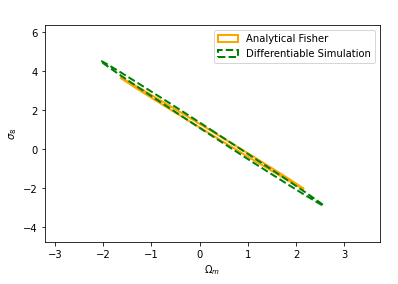

In [117]:
ax = plt.axes()
#ax.set_facecolor('black')
ax1=plot_contours(F_r, params, fill=False,label='Analytical Fisher',color='orange', lw=2,);
ax2=plot_contours(F1_r, params, fill=False,label='Differentiable Simulation', color='green', lw=2, linestyle='dashed');
#ax.tick_params(colors='white', which='both')
xlabel('$\Omega_m$')#,color='white')
ylabel('$\sigma_8$')#,color='white');
title('Forecasted constraints on $\Omega_m$ and $\sigma_8$ from Power Spectrum ',color='white')
plt.legend([ax1,ax2],['Analytical Fisher','Differentiable Simulation'])
#savefig('fisher_black.png',dpi=150)